In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Generate data
> $y = f(x) + e(x)$ where
> $f(x) = 5sin(x^2) + 2cos(x)^3$, $e(x) \sim N(0, 0.8*(|x|+1)^{1.2})$

In [2]:
n = 80  # number of samples
x = np.random.uniform(low = -1, high=3, size = n)
eps = np.random.normal([0]*n, (np.power((np.abs(x)+1),1.5))*0.5, n)
y_model = np.sin(np.power(x,2)*1.5)*5 + np.power(np.cos(x),3)*2
y = y_model + eps

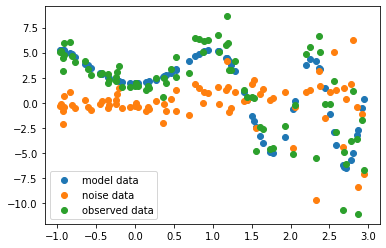

In [3]:
plt.scatter(x, y_model, label='model data')
plt.scatter(x, eps, label='noise data')
plt.scatter(x, y, label = 'observed data')
plt.legend()

In [4]:
x_train = x.copy()
y_train = y.copy()

# Train model to fit data (x,y)
> Assume f and e are unknown to us

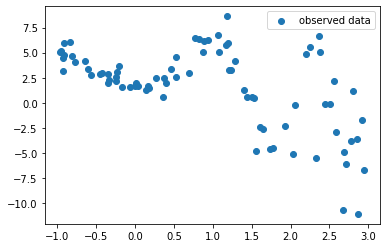

In [5]:
plt.scatter(x_train, y_train, label = 'observed data')
plt.legend()

In [6]:
def B(x, m, i, t):
    '''
        Compute the i-th BSpline value at x with knots at t and order of m, i.e., B_{i,m}(x)
        see https://en.wikipedia.org/wiki/B-spline
    '''
    if m == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+m] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+m] - t[i]) * B(x, m-1, i, t)
    if t[i+m+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+m+1] - x)/(t[i+m+1] - t[i+1]) * B(x, m-1, i+1, t)
    return c1 + c2

In [7]:
xmin = -1
xmax = 3
K = 6       # K knots uniformly in the middle
M = 4       # order of M
t = np.hstack((np.linspace(xmin, xmin, M-1), np.linspace(xmin, xmax, K+2),np.linspace(xmax, xmax, M-1)))   # knots

In [8]:
def get_basis(x):
    '''
        Get Bspline basis for each value in x
        Return 2d array, with each row j represents each basis function's value at x_j
    '''
    res = np.zeros(shape=(len(x), K+M))
    for i in range(K+M):
        for j in range(len(x)):
            res[j, i] = B(x[j], 3, i, t)
    return res

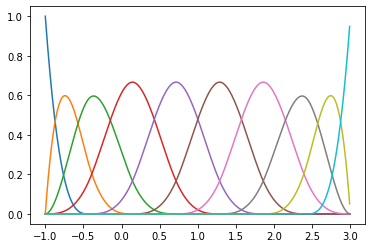

In [9]:
# setup basis B-Splines of order M with knots t
npoints = 400
x = np.linspace(-1, 3, npoints, endpoint=False)

x_basis = get_basis(x)

for i in range(K+M):
    plt.plot(x, x_basis[:,i])

In [10]:
idx = np.argsort(x_train)

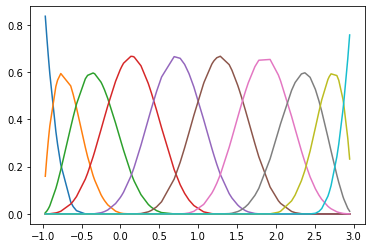

In [11]:
x_basis = get_basis(x_train)

for i in range(K+M):
    plt.plot(x_train[idx], x_basis[idx,i])

In [12]:
b = np.linalg.inv(x_basis.T @ x_basis) @ x_basis.T @ y_train
y_pred = x_basis @ b

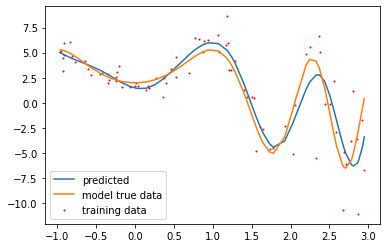

In [13]:
plt.scatter(x_train[idx], y_train[idx], label='training data', color='red', s=1)
plt.plot(x_train[idx], y_pred[idx], label='predicted')
plt.plot(x_train[idx], y_model[idx], label='model true data')
plt.legend()

# Confidence interval

## Analytical solution assuming noise are i.i.d. normal.
> Let $H=(h_{ij})$ be the $N\times p$ matrix with element $h_{ij} = B_{j,M}(x_i)$ ($j$-th basis function evaluated at $x_i$).   
> We have $\beta = (H^TH)^{-1}H^Ty$, $Var(\beta) = (H^TH)^{-1}\hat{\sigma}^2$, $Var(\hat{y}(x_i)) = h(x_i)Var(\beta)h(x_i)^T$

Text(0.5, 1.0, 'residual plot')

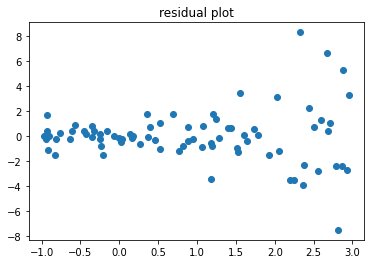

In [14]:
plt.scatter(x_train, y_pred - y_train)
plt.title('residual plot')

In [15]:
np.linalg.norm([1,1],2)

1.4142135623730951

In [16]:
var_hat = np.dot(y_pred - y_train,y_pred - y_train)/(len(y_train)-1)

In [17]:
se = np.sqrt(((x_basis@np.linalg.inv(x_basis.T @ x_basis)@x_basis.T)*var_hat).diagonal())

In [18]:
idx = np.argsort(x_train)

(-12.0, 12.0)

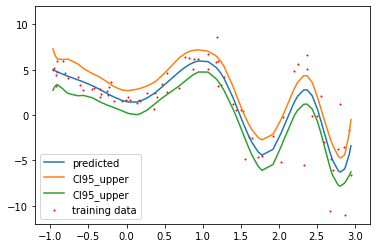

In [31]:
plt.scatter(x_train[idx], y_train[idx], label='training data', color='red', s=1)
plt.plot(x_train[idx], y_pred[idx], label='predicted')
plt.plot(x_train[idx], y_pred[idx]+1.96*se[idx], label='CI95_upper')
plt.plot(x_train[idx], y_pred[idx]-1.96*se[idx], label='CI95_upper')
# plt.plot(x_train[idx], y_model[idx], label='model true data')
plt.legend()
plt.xlim((-1.2,3.2))
plt.ylim((-12,12))

## Nonparametric bootstrap
> Model free, resampling from training data and train the model

In [20]:
def train_model(x_train, y_train):
    x_basis = get_basis(x_train)
    b = np.linalg.inv(x_basis.T @ x_basis) @ x_basis.T @ y_train
    return b

def model_predict(b, x):
    x_basis = get_basis(x)
    y_pred = x_basis @ b
    return y_pred

In [24]:
B_samples = 200 # bootstrap samples
x_plot = np.linspace(xmin, xmax, 100, endpoint=False)
y_plot = np.zeros(shape=(B_samples, len(x_plot)))

for b in range(B_samples):
    selected_idx = np.random.randint(0, n, n)
    beta = train_model(x_train[selected_idx],y_train[selected_idx])
    y_plot[b] = model_predict(beta, x_plot)

(-12.0, 12.0)

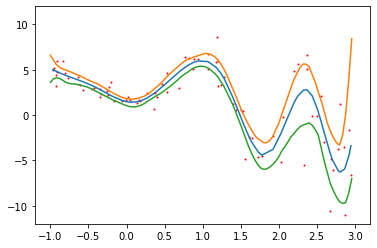

In [32]:
plt.scatter(x_train, y_train, label='training data', color='red', s=1)
plt.plot(x_train[idx], y_pred[idx], label='predicted')
plt.plot(x_plot, np.percentile(y_plot, 97.5, axis=0), label='CI95_upper')
plt.plot(x_plot, np.percentile(y_plot, 2.5, axis=0), label='CI95_lower')
plt.xlim((-1.2,3.2))
plt.ylim((-12,12))

## Parametric bootstrap
> Assume we know the noise is $\epsilon_i \sim N(0, \hat{\sigma}^2)$. Simulate new response from $y_i = \hat{f}(x_i) + \epsilon_i$. Using the simulated data to train the model. Repeat the process by B=200 times and get confidence interval. As $B$ goes to infinity, it will converge to the analytical solution.